In [36]:
# Add the file to the staging area
!git add PredictNHL.ipynb

# Commit the file with a descriptive message
!git commit -m "Add PredictNHL.ipynb"

# Push the file to the main branch on GitHub
!git push origin main


[main de626fa] Add PredictNHL.ipynb
 1 file changed, 96 insertions(+), 368 deletions(-)


Auto packing the repository in background for optimum performance.
See "git help gc" for manual housekeeping.
To https://github.com/nic01as1/NHLPredictor.git
   adafdfa..de626fa  main -> main


In [33]:
!pip install tensorflow
!pip install xgboost
!pip install streamlit
!pip install imbalanced-learn
!pip install shap
!pip install statsmodels
!pip install 



[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/11.1 MB 3.6 MB/s eta 0:00:04
   - -------------------------------------- 0.4/11.1 MB 3.7 MB/s eta 0:00:03
   -- ------------------------------------- 0.6/11.1 MB 4.5 MB/s eta 0:00:03
   --- ------------------------------------ 0.9/11.1 MB 5.2 MB/s eta 0:00:02
   ---- ----------------------------------- 1.2/11.1 MB 5.4 MB/s eta 0:00:02
   ----- ---------------------------------- 1.6/11.1 MB 5.5 MB/s eta 0:00:02
   ------ --------------------------------- 1.9/11.1 MB 6.0 MB/s eta 0:00:02
   -------- ------------------------------- 2.3/11.1 MB 6.0 MB/s eta 0:00:02
   --------- ------------------------------ 2.7/11.1 MB 6.5 MB/s eta 0:00:02
   ----------- ---------------------------- 3.1/11.1 MB 6.8 MB/s eta 0:00:02
   ------------ --------------------------- 3.5/11.1 MB 7.0 MB/s eta 0:00:02
   -------------- ------------------------- 4.0/11.1 MB 7.2 MB/s eta 0:00:01
   ---

  You can safely remove it manually.

[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_val_score


In [2]:
#J'ai ajouté la différence en valeur plutôt quMune valeur binaire pour les ranks et ça a amélioré le modèle ! Rank_Difference

In [3]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Load the dataset
url = 'Results24-25NHL.xlsx'
results = pd.read_excel(url, engine='openpyxl')

results.head()

,Visitor,Score,Home,Score.1,HomeWin,HomeL10,VisitorL10,Home Winrate,AwayWinrate,Rank Home,Rank Visitor,HomeWinStreak
0,New Jersey Devils,4,Buffalo Sabres,1,0,2,6,0.315789,0.705882,29,3,2
1,Buffalo Sabres,1,New Jersey Devils,3,1,6,2,0.550000,0.375000,3,29,0
2,St. Louis Blues,3,Seattle Kraken,2,0,3,4,0.444444,0.476190,24,19,0
3,Boston Bruins,4,Florida Panthers,6,1,6,6,0.588235,0.470588,7,12,0
4,Chicago Blackhawks,2,Utah Hockey Club,5,1,6,4,0.333333,0.250000,18,32,0


In [4]:
from sklearn.metrics import f1_score, make_scorer, classification_report

# Lets designate a scorer object with the F1 score
scorer = make_scorer(f1_score, pos_label=None, average='weighted')

In [5]:
# Calculate the number of times home teams won in the dataset
n_games = results["HomeWin"].count()
n_homewins = results["HomeWin"].sum()
win_percentage = n_homewins / n_games

y_true = np.asarray(results["HomeWin"].values).ravel()

# Create a new variable for the rank difference
results["Rank_Difference"] = results["Rank Visitor"] - results["Rank Home"]


print("Overall Home Win Percentage in Dataset: {0:.1f}%".format(100 * win_percentage))

results.head()

Overall Home Win Percentage in Dataset: 53.6%


,Visitor,Score,Home,Score.1,HomeWin,HomeL10,VisitorL10,Home Winrate,AwayWinrate,Rank Home,Rank Visitor,HomeWinStreak,Rank_Difference
0,New Jersey Devils,4,Buffalo Sabres,1,0,2,6,0.315789,0.705882,29,3,2,-26
1,Buffalo Sabres,1,New Jersey Devils,3,1,6,2,0.550000,0.375000,3,29,0,26
2,St. Louis Blues,3,Seattle Kraken,2,0,3,4,0.444444,0.476190,24,19,0,-5
3,Boston Bruins,4,Florida Panthers,6,1,6,6,0.588235,0.470588,7,12,0,5
4,Chicago Blackhawks,2,Utah Hockey Club,5,1,6,4,0.333333,0.250000,18,32,0,14


In [6]:
from sklearn.metrics import f1_score
y_pred = [1] * len(y_true)
print("F1 Score: {:.4f}".format(f1_score(y_true, y_pred, pos_label=None, average="weighted")))

F1 Score: 0.3741


In [7]:

# Create a new dataframe with just the necessary features
X_previousWins = results[["HomeL10", "VisitorL10"]].values

# The object, tree_clf, has the Decision Tree Classifier ready
tree_clf = DecisionTreeClassifier(random_state=10)

# Create the F1 scorer
scorer = make_scorer(f1_score, average="weighted")

# Compute the F1 Score
scores = cross_val_score(tree_clf, X_previousWins, y_true, scoring=scorer)
print("Using only our new attributes, whether each team won their last match, we get an F1 Score of:")
print("F1 Score: {0:.4f}".format(np.mean(scores)))

Using only our new attributes, whether each team won their last match, we get an F1 Score of:
F1 Score: 0.5100


In [8]:
df = pd.DataFrame(index=['Baseline', 'Last Win'],data=[(0.3741, 0),(0.51, 0.51-0.3741)], \
                  columns=['F1 Score', 'Overall Performance Boost'])
df

,F1 Score,Overall Performance Boost
Baseline,0.3741,0.0000
Last Win,0.5100,0.1359


In [9]:
# Lets run the decision tree classifier again to see if the F1 Score has improved
tree_clf = DecisionTreeClassifier(random_state = 10)
X_winrate = results[["HomeL10", "VisitorL10", "Home Winrate", "AwayWinrate"]].values
scores = cross_val_score(tree_clf, X_winrate, y_true, scoring=scorer)
print("By adding win streaks, our new F1 score is:")
print("F1 Score: {0:.4f}".format(np.mean(scores)))

By adding win streaks, our new F1 score is:
F1 Score: 0.5096


In [10]:
df2 = pd.DataFrame(
    index=['Last Win & Winrate'],
    data=[(0.5096, 0.5096 - 0.51)],
    columns=['F1 Score', 'Overall Performance Boost']
)

# Use pd.concat to append
df = pd.concat([df, df2])
print(df)

                    F1 Score  Overall Performance Boost
Baseline              0.3741                     0.0000
Last Win              0.5100                     0.1359
Last Win & Winrate    0.5096                    -0.0004


In [11]:
print(results.columns)


Index(['Visitor', 'Score', 'Home', 'Score.1', 'HomeWin', 'HomeL10',
       'VisitorL10', 'Home Winrate', 'AwayWinrate', 'Rank Home',
       'Rank Visitor', 'HomeWinStreak', 'Rank_Difference'],
      dtype='object')


In [12]:
# Create binary variable: 1 if Home Team rank is lower (stronger), else 0
results['Home Stronger'] = (results['Rank Home'] < results['Rank Visitor']).astype(int)

print(results)

                 Visitor  Score                  Home  Score.1  HomeWin  \
0      New Jersey Devils      4        Buffalo Sabres        1        0   
1         Buffalo Sabres      1     New Jersey Devils        3        1   
2        St. Louis Blues      3        Seattle Kraken        2        0   
3          Boston Bruins      4      Florida Panthers        6        1   
4     Chicago Blackhawks      2      Utah Hockey Club        5        1   
..                   ...    ...                   ...      ...      ...   
551  Carolina Hurricanes      2   Nashville Predators        5        1   
552   Chicago Blackhawks      3        Minnesota Wild        4        1   
553      San Jose Sharks      3     Vancouver Canucks        4        1   
554         Dallas Stars      3      Utah Hockey Club        2        0   
555        Anaheim Ducks      1  Vegas Golden Knights        3        1   

     HomeL10  VisitorL10  Home Winrate  AwayWinrate  Rank Home  Rank Visitor  \
0          2       

In [13]:
# Lets build our Decision Tree Classifier to see if there are any improvements
X_homehigher = results[["HomeL10", "VisitorL10", "Home Winrate", "AwayWinrate", "Rank_Difference"]].values

tree_clf = DecisionTreeClassifier(random_state=10)
scores = cross_val_score(tree_clf, X_homehigher, y_true, scoring=scorer)
print("By considering last seasons' rankings, the new F1 score is:")
print("F1: {0:.4f}".format(np.mean(scores)))

By considering last seasons' rankings, the new F1 score is:
F1: 0.5152


In [14]:
df3 = pd.DataFrame(
    index=['Last Win & Winrate & Stronger'],
    data=[(0.5152, 0.5152-0.5096)],
    columns=['F1 Score', 'Overall Performance Boost']
)

# Use pd.concat to append
df = pd.concat([df, df3])
print(df)

                               F1 Score  Overall Performance Boost
Baseline                         0.3741                     0.0000
Last Win                         0.5100                     0.1359
Last Win & Winrate               0.5096                    -0.0004
Last Win & Winrate & Stronger    0.5152                     0.0056


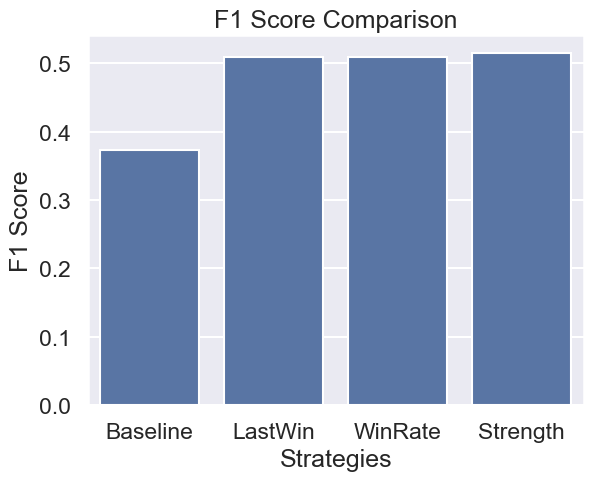

In [15]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_area_auto_adjustable

labels = ["Baseline", "LastWin", "WinRate", "Strength"]
scores = [0.3728, 0.5100, 0.5096, 0.5152]

sns.set(style="darkgrid", context="talk")

# Create the barplot
sns.barplot(x=labels, y=scores)

# Add labels and title
plt.xlabel("Strategies")
plt.ylabel("F1 Score")
plt.title("F1 Score Comparison")
plt.show()


In [16]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
encoding = LabelEncoder() # encoding object has LabelEncoder ready to use
encoding.fit(results["Home"].values) # give each team a number to identify them by

LabelEncoder()

In [17]:
home_teams = encoding.transform(results["Home"].values)
visitor_teams = encoding.transform(results["Visitor"].values)

# vstack allows you to stack a sequence of arrays vertically - in this case we do it to make easy comparisons
X_teams = np.vstack([home_teams, visitor_teams]).T

X_teams[:5], X_teams.shape

(array([[ 2, 16],
        [16,  2],
        [23, 24],
        [11,  1],
        [27,  5]]),
 (556, 2))

In [18]:
# Prepare the One Hot Encoder
onehot = OneHotEncoder()
X_teams = onehot.fit_transform(X_teams).toarray()


In [19]:

X_teams.shape # see matrix dimensions

(556, 64)

In [20]:
# Lets build our model using the Decision Tree Classifier
tree_clf = DecisionTreeClassifier(random_state=10)
scores = cross_val_score(tree_clf, X_teams, y_true, scoring=scorer)

# Note: The only feature is the encoder we just made
print("The F1 score using encoded teams is the following: {0:.4f}".format(np.mean(scores)))

The F1 score using encoded teams is the following: 0.5654


In [21]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=10)
scores = cross_val_score(forest_clf, X_teams, y_true, scoring=scorer)
print("The F1 score using Random Forest Classifier is the following: {0:.4f}".format(np.mean(scores)))

The F1 score using Random Forest Classifier is the following: 0.5823


In [22]:
parameter_space = {
    "max_features": [2, 10, 50, 'auto'],
    "n_estimators": [50, 100, 200],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": [1,2,4,6],
}

forest_clf = RandomForestClassifier(random_state=10)
grid = GridSearchCV(forest_clf, parameter_space, scoring=scorer)
grid.fit(X_teams, y_true)

# View results
print("F1: {0:.4f}".format(grid.best_score_))
print(grid.best_estimator_)

F1: 0.5819
RandomForestClassifier(criterion='entropy', max_features=2, random_state=10)


In [23]:
X_all = np.hstack([X_homehigher, X_teams])
print(X_all.shape)
# Decision Tree Classifier
tree_clf = DecisionTreeClassifier(random_state=10)
scores = cross_val_score(tree_clf, X_all, y_true, scoring=scorer)
print("F1 score: {0:.4f}".format(np.mean(scores)))

(556, 69)
F1 score: 0.5416


In [24]:
# Random Forest Classifier
parameter_space = {
    "max_features": [2, 10, 50, 'auto'],
    "n_estimators": [50, 100, 200],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": [1,2,4,6],
}

forest_clf = RandomForestClassifier(random_state=10)
grid = GridSearchCV(forest_clf, parameter_space, scoring=scorer)
grid.fit(X_all, y_true)
print("F1 score: {0:.4f}".format(grid.best_score_))
print(grid.best_estimator_)

F1 score: 0.6442
RandomForestClassifier(max_features=50, min_samples_leaf=6, n_estimators=200,
                       random_state=10)


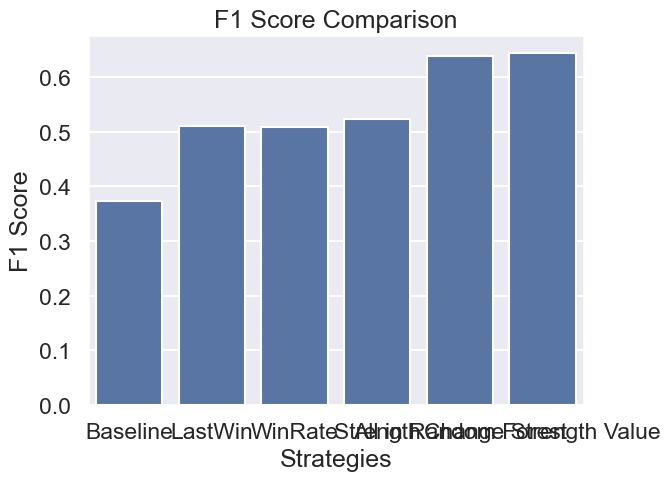

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_area_auto_adjustable
labels = ["Baseline", "LastWin", "WinRate", "Strength", 'All in Random Forest','Change Strength Value']
scores = [0.3728, 0.5100, 0.5096, 0.5226, 0.6381, 0.6442]

sns.set(style="darkgrid", context="talk")

# Create the barplot
sns.barplot(x=labels, y=scores)

# Add labels and title
plt.xlabel("Strategies")
plt.ylabel("F1 Score")
plt.title("F1 Score Comparison")
plt.show()


In [29]:
# List of all teams (from encoding.classes_)
teams = list(encoding.classes_)

# Display the list of teams
print("Available Teams:")
for i, team in enumerate(teams):
    print(f"{i + 1}: {team}")

# Let the user select home and away teams by number
home_team_index = int(input("Select the home team by number: ")) - 1
away_team_index = int(input("Select the away team by number: ")) - 1

# Get the team names based on user selection
home_team = teams[home_team_index]
away_team = teams[away_team_index]

print(f"Home Team: {home_team}")
print(f"Away Team: {away_team}")

# Retrieve features
home_features = results[results['Home'] == home_team].iloc[0][["HomeL10", "Home Winrate", "Rank_Difference"]].values
away_features = results[results['Visitor'] == away_team].iloc[0][["VisitorL10", "AwayWinrate"]].values

# One-hot encode teams
one_hot_home = [1 if team == home_team else 0 for team in teams]
one_hot_away = [1 if team == away_team else 0 for team in teams]

# Combine features into a single input vector
combined_features = np.hstack([home_features, away_features, one_hot_home, one_hot_away])

# Ensure the input vector matches the model's expected format
input_vector = combined_features.reshape(1, -1)  # Reshape to 2D array for prediction

# Make the prediction
predicted_prob = grid.best_estimator_.predict_proba(input_vector)

# Extract probabilities for home and away teams
home_team_prob = predicted_prob[0][1]  # Probability of home team winning
away_team_prob = predicted_prob[0][0]  # Probability of away team winning

# Input: Gambling site odds
home_team_odds = float(input(f"Enter the odds for {home_team}: "))
away_team_odds = float(input(f"Enter the odds for {away_team}: "))

# Kelly Criterion Formula
def kelly_criterion(prob, odds):
    b = odds - 1
    q = 1 - prob
    return max(0, (b * prob - q) / b)  # Return 0 if Kelly fraction is negative

# Calculate Kelly Criterion for both teams
home_kelly = kelly_criterion(home_team_prob, home_team_odds)
away_kelly = kelly_criterion(away_team_prob, away_team_odds)

# Determine the best bet
if home_kelly > away_kelly:
    print(f"Bet on {home_team}. Kelly Criterion suggests betting {home_kelly:.2%} of your bankroll.")
elif away_kelly > home_kelly:
    print(f"Bet on {away_team}. Kelly Criterion suggests betting {away_kelly:.2%} of your bankroll.")
else:
    print("Neither bet has a positive expected value according to the Kelly Criterion.")

# Output additional details
print(f"Home Team: {home_team}, Probability: {home_team_prob:.2%}, Odds: {home_team_odds}")
print(f"Away Team: {away_team}, Probability: {away_team_prob:.2%}, Odds: {away_team_odds}")
print(f"Kelly Criterion (Home): {home_kelly:.2%}")
print(f"Kelly Criterion (Away): {away_kelly:.2%}")


Available Teams:
1: Anaheim Ducks
2: Boston Bruins
3: Buffalo Sabres
4: Calgary Flames
5: Carolina Hurricanes
6: Chicago Blackhawks
7: Colorado Avalanche
8: Columbus Blue Jackets
9: Dallas Stars
10: Detroit Red Wings
11: Edmonton Oilers
12: Florida Panthers
13: Los Angeles Kings
14: Minnesota Wild
15: Montreal Canadiens
16: Nashville Predators
17: New Jersey Devils
18: New York Islanders
19: New York Rangers
20: Ottawa Senators
21: Philadelphia Flyers
22: Pittsburgh Penguins
23: San Jose Sharks
24: Seattle Kraken
25: St. Louis Blues
26: Tampa Bay Lightning
27: Toronto Maple Leafs
28: Utah Hockey Club
29: Vancouver Canucks
30: Vegas Golden Knights
31: Washington Capitals
32: Winnipeg Jets


Select the home team by number:  13
Select the away team by number:  4


Home Team: Los Angeles Kings
Away Team: Calgary Flames


Enter the odds for Los Angeles Kings:  2
Enter the odds for Calgary Flames:  2


Bet on Los Angeles Kings. Kelly Criterion suggests betting 30.93% of your bankroll.
Home Team: Los Angeles Kings, Probability: 65.46%, Odds: 2.0
Away Team: Calgary Flames, Probability: 34.54%, Odds: 2.0
Kelly Criterion (Home): 30.93%
Kelly Criterion (Away): 0.00%
